# Load data

In [1]:
from datasets import load_dataset
import os

data_path = "../data/elaborations"

data_files_c2s = {
    'train': os.path.join(data_path,"train","train_ds_c2s.csv"),      
    'validation': os.path.join(data_path,"validation","valid_ds_c2s.csv"),  
    'test': os.path.join(data_path,"test","test_ds_c2s.csv")         
}

data_files_c2s_masked = {
    'train': os.path.join(data_path,"train","train_ds_c2s_masked_llama.csv"),      
    'validation': os.path.join(data_path,"validation","valid_ds_c2s_masked_llama.csv"),  
    'test': os.path.join(data_path,"test","test_ds_c2s_masked_llama.csv")         
}

data_files_c2sp = {
    'train': os.path.join(data_path,"train","train_ds_c2sp.csv"),      
    'validation': os.path.join(data_path,"validation","valid_ds_c2sp.csv"),  
    'test': os.path.join(data_path,"test","test_ds_c2sp.csv")         
}

data_files_c2sp_masked = {
    'train': os.path.join(data_path,"train","train_ds_c2sp_masked_llama.csv"),      
    'validation': os.path.join(data_path,"validation","valid_ds_c2sp_masked_llama.csv"),  
    'test': os.path.join(data_path,"test","test_ds_c2sp_masked_llama.csv")         
}

data_files_c4s = {
    'train': os.path.join(data_path,"train","train_ds_c4s.csv"),      
    'validation': os.path.join(data_path,"validation","valid_ds_c4s.csv"),  
    'test': os.path.join(data_path,"test","test_ds_c4s.csv")         
}

data_files_c4s_masked = {
    'train': os.path.join(data_path,"train","train_ds_c4s_masked_llama.csv"),      
    'validation': os.path.join(data_path,"validation","valid_ds_c4s_masked_llama.csv"),  
    'test': os.path.join(data_path,"test","test_ds_c4s_masked_llama.csv")         
}


data_files_c2os = {
    'train': os.path.join(data_path,"train","train_ds_c2os.csv"),      
    'validation': os.path.join(data_path,"validation","valid_ds_c2os.csv"),  
    'test': os.path.join(data_path,"test","test_ds_c2os.csv")         
}

data_files_c2osp = {
    'train': os.path.join(data_path,"train","train_ds_c2osp.csv"),      
    'validation': os.path.join(data_path,"validation","valid_ds_c2osp.csv"),  
    'test': os.path.join(data_path,"test","test_ds_c2osp.csv")         
}

data_files_c4sp = {
    'train': os.path.join(data_path,"train","train_ds_c4sp.csv"),      
    'validation': os.path.join(data_path,"validation","valid_ds_c4sp.csv"),  
    'test': os.path.join(data_path,"test","test_ds_c4sp.csv")         
}

data_files_c4sp_masked = {
    'train': os.path.join(data_path,"train","train_ds_c4sp_masked_llama.csv"),      
    'validation': os.path.join(data_path,"validation","valid_ds_c4sp_masked_llama.csv"),  
    'test': os.path.join(data_path,"test","test_ds_c4sp_masked_llama.csv")         
}

data_files_c4osp = {
    'train': os.path.join(data_path,"train","train_ds_c4osp.csv"),      
    'validation': os.path.join(data_path,"validation","valid_ds_c4osp.csv"),  
    'test': os.path.join(data_path,"test","test_ds_c4osp.csv")         
}

dataset = load_dataset('csv', data_files=data_files_c4sp)
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['doc_num', 'source_text', 'label_text', 'elaboration_sentence', 'contextual_specificity_rating'],
        num_rows: 1049
    })
    validation: Dataset({
        features: ['doc_num', 'source_text', 'label_text', 'elaboration_sentence', 'contextual_specificity_rating'],
        num_rows: 134
    })
    test: Dataset({
        features: ['doc_num', 'source_text', 'label_text', 'elaboration_sentence', 'contextual_specificity_rating'],
        num_rows: 116
    })
})


## Check length

In [2]:
def count_texts_over_word_limit(dataset_dict, column, word_limit=150):
    word_count = {}

    for split in dataset_dict:
        dataset = dataset_dict[split]
        count_over_limit = 0

        for example in dataset:
            try:
                num_words = len(example[column].split()) # count on spaces
                if num_words > word_limit:
                    count_over_limit += 1
            except AttributeError as e: 
                print(f"Empty string in doc num: {example['doc_num']}")
                continue 

        word_count[split] = count_over_limit

    return word_count

count_texts_over_word_limit(dataset, column='source_text')

{'train': 0, 'validation': 0, 'test': 0}

# Load the model

In [2]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
from trl import setup_chat_format
from trl.extras.dataset_formatting import conversations_formatting_function
torch.cuda.empty_cache()
# LLAMA 3.2 3B
tokenizer = AutoTokenizer.from_pretrained('meta-llama/Llama-3.2-3B', cache_dir="../models/llama/") 
model =  AutoModelForCausalLM.from_pretrained('meta-llama/Llama-3.2-3B', cache_dir="../models/llama/", device_map ={'':torch.cuda.current_device()})

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

## Config

In [3]:
# set the pad_token for llama 3.2 3B
tokenizer.pad_token = tokenizer.eos_token #"<|finetune_right_pad_id|>" 

# Tokenize dataset

In [4]:
import numpy as np

def adjust_labels(example):
    # replace padding token in labels with -100 for correct loss calculation
    example["labels"] = [
        -100 if token == tokenizer.pad_token_id else token
        for token in example["labels"]
    ]
    return example

def tokenize_func(examples):
    # inputs
    inputs = tokenizer(examples['source_text'], truncation=True, padding="max_length",max_length=64) # padding="max_length"
    # labels
    labels = tokenizer(examples['elaboration_sentence'],truncation=True,padding="max_length", max_length=64)
    # set the labels in the input dictionary
    inputs['labels'] = labels['input_ids'] #labels['input_ids'] or np.array(labels['input_ids'])
    return inputs

tokenized_dataset = dataset.map(tokenize_func, batched=True)
#tokenized_dataset = tokenized_dataset.map(adjust_labels, batched=False)
#tokenized_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

# Fine-tune

In [3]:
from model_utils import calculate_logging_steps
steps_per_epoch, logging_steps = calculate_logging_steps(dataset, batch_size=32, logging_frequency=6)

Steps per epoch: 32
Logging steps: 5


## No instruct

In [6]:
from trl import SFTConfig, SFTTrainer
from transformers import DataCollatorForLanguageModeling


model.train()

# data collator
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, 
    mlm=False,  # no masked language modeling 
)

logs_dir = "../models/llama/llama3.2-news-ft/logs/logs-c2s"

training_args = SFTConfig(
    output_dir="../models/llama/llama3.2-news-ft/results/results-c2s",
    max_seq_length= 64,
    eval_strategy="epoch",  
    save_strategy="no",  
    logging_strategy="steps",  
    logging_steps=6, 
    learning_rate=1e-6,  
    per_device_train_batch_size=32, 
    per_device_eval_batch_size=32,  
    num_train_epochs=3,  
    weight_decay=0.01,  
    warmup_steps=2,  
    optim="paged_adamw_8bit",  
    fp16=True,  
    logging_dir=logs_dir, 
    push_to_hub=False,
    group_by_length=True,  
    save_total_limit=0,

)

trainer = SFTTrainer(
    model,
    train_dataset=tokenized_dataset["train"],  
    eval_dataset=tokenized_dataset["validation"],  
    args=training_args,   
    data_collator=data_collator, 
)

model.config.use_cache = False

In [7]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,2.960200,3.143848
2,2.700500,3.052567
3,2.559600,3.032315


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


TrainOutput(global_step=99, training_loss=2.8347623805807096, metrics={'train_runtime': 30.1256, 'train_samples_per_second': 104.164, 'train_steps_per_second': 3.286, 'total_flos': 3396568057380864.0, 'train_loss': 2.8347623805807096, 'epoch': 3.0})

### Learning curve

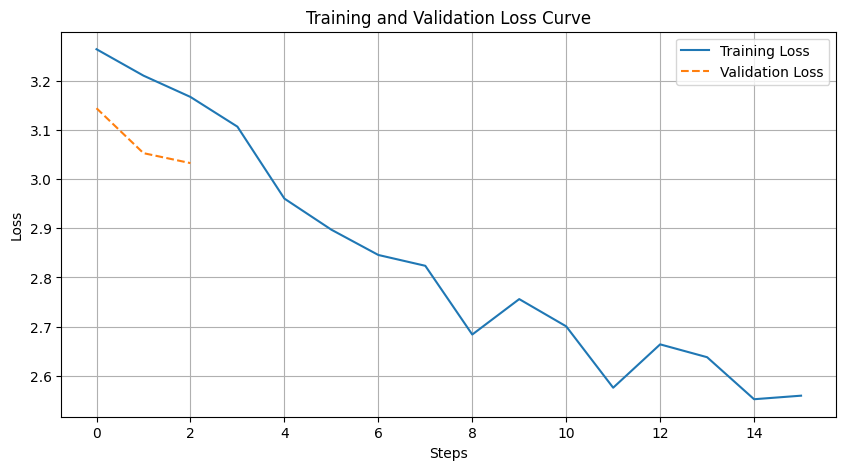

In [8]:
from model_utils import plot_loss_curves
plot_loss_curves(trainer)

## Instruct

https://huggingface.co/docs/trl/en/sft_trainer

In [3]:
ZERO_SHOT_SYSTEM_PROMPT = """You are an expert in generating exactly one short explanatory sentence (made up of around 10 words or fewer) in a plain English for a given context text. 
Your task is to provide additional information related to the complex statement, term, action, or concept that is semantically missing from the context text.
You may do this by offering a definition, examples, background knowledge, general statements, a description of the flow of actions, or an explanation of the reason or result of the target action.
The tone should be plain and simple!
Return only ONE short concise explanatory sentence!
"""

In [3]:
# text with elaboration sentence masked -> elaboration sentence
SYSTEM_PROMPT_MASKED = """You are an expert in generating exactly one short explanatory sentence (made up of around 10 words or fewer) in a plain English for a given context text. 
Your task is to provide additional information related to the complex statement, term, action, or concept that is semantically missing from the context text.
You may do this by offering a definition, examples, background knowledge, general statements, a description of the flow of actions, or an explanation of the reason or result of the target action.
Your task is to replace the `<explanatory sentence>` tag in the provided text with the explanation sentence you generate.
Return only the explanation sentence itself, without any tags, formatting, or additional text.
The tone should be plain and simple!
Return only ONE short concise explanatory sentence!
"""

In [12]:
# text with elaboration sentence masked -> text with filled-out elaboration sentence
SYSTEM_PROMPT_MASKED2 = """You are an expert in generating exactly one short explanatory sentence (made up of around 10 words or fewer) in a plain English for a given context text. 
Your task is to replace the `<explanatory sentence>` tag in the provided text with ONE concise explanation sentence that adds relevant information to clarify a complex statement, term, action, or concept that is semantically missing from the text.
The tone should be plain and simple!
"""

In [11]:
#You may do this by offering a definition, examples, background knowledge, general statements, a description of the flow of actions, or an explanation of the reason or result of the target action.


In [3]:
SYSTEM_PROMPT_SHORT = """You are an expert in generating exactly ONE short concise explanation sentence (made up of around 10 words or fewer) in a plain English for a given context text. 
The tone should be plain and simple!"""

### ChatMLFormat 

In [4]:
model, tokenizer = setup_chat_format(model, tokenizer)
formatting_func = conversations_formatting_function(tokenizer, "messages")

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


In [30]:
formatted_example = formatting_func(formatted_train_dataset[0])
print(formatted_example)

<|im_start|>system
You are an expert in generating exactly one short explanatory sentence (made up of around 10 words or fewer) in a plain English for a given context text. 
Your task is to provide additional information related to the complex statement, term, action, or concept that is semantically missing from the context text.
You may do this by offering a definition, examples, background knowledge, general statements, a description of the flow of actions, or an explanation of the reason or result of the target action.
Your task is to replace the `<explanatory sentence>` tag in the provided text with the explanation sentence you generate.
Return only the explanation sentence itself, without any tags, formatting, or additional text.
The tone should be plain and simple!
Return only ONE short concise explanatory sentence!
<|im_end|>
<|im_start|>user
Context: A watermark is an image that can be seen in the paper when you hold it up to the light. Investigators say Kellogg tried to copy t

In [10]:
formatted_train_dataset[0]["messages"]

[{'content': 'You are an expert in generating exactly one short explanatory sentence (made up of around 10 words or fewer) in a plain English for a given context text. \nYour task is to replace the `<explanatory sentence>` tag in the provided text with ONE concise explanation sentence that adds relevant information to clarify a complex statement, term, action, or concept that is semantically missing from the text.\nYou may do this by offering a definition, examples, background knowledge, general statements, a description of the flow of actions, or an explanation of the reason or result of the target action.\nThe tone should be plain and simple!\n',
  'role': 'system'},
 {'content': 'A watermark is an image that can be seen in the paper when you hold it up to the light. Investigators say Kellogg tried to copy the watermark. <explanatory sentence>',
  'role': 'user'},
 {'content': "A watermark is an image that can be seen in the paper when you hold it up to the light. Investigators say K

In [5]:
def format_example(example):
    return {
        "messages": [
            {"role": "system", "content": SYSTEM_PROMPT_SHORT},
            {"role": "user", "content": f"{example['source_text']}"}, # Context or Text
            {"role": "assistant", "content":  f"{example['elaboration_sentence']}"}
        ]
    }

def format_test_example(example):
    return {
        "messages": [
            #{"role": "system", "content": SYSTEM_PROMPT_MASKED},
            {"role": "user", "content": f"{example['source_text']}"},
             {"role": "assistant", "content":""}
        ]
    }

formatted_train_dataset = dataset["train"].map(format_example)
formatted_validation_dataset = dataset["validation"].map(format_example)
formatted_test_dataset = dataset["test"].map(format_test_example)

Map:   0%|          | 0/1049 [00:00<?, ? examples/s]

Map:   0%|          | 0/134 [00:00<?, ? examples/s]

In [11]:
def calculate_mean_message_length(dataset):
    total_length = 0
    message_count = 0

    for entry in dataset:
        messages = entry.get('messages', [])
        for message in messages:
            content = message.get('content', "")
            total_length += len(content.split())  # Count words in the content
            message_count += 1

    return total_length / message_count if message_count > 0 else 0

mean_length = calculate_mean_message_length(formatted_train_dataset)
print(f"Mean length of messages: {mean_length}")

Mean length of messages: 52.296790594216716


## Alpaca format

In [4]:
# set the pad_token for llama 3.2 3B
tokenizer.pad_token = tokenizer.eos_token

In [5]:
alpaca_prompt = """
### Instruction:
You are an expert in generating exactly one short explanatory sentence (made up of around 10 words or fewer) in a plain English for a given context text. 
Your task is to provide additional information related to the complex statement, term, action, or concept that is semantically missing from the context text.
You may do this by offering a definition, examples, background knowledge, general statements, a description of the flow of actions, or an explanation of the reason or result of the target action.
Your task is to replace the `<explanatory sentence>` tag in the provided text with the explanation sentence you generate.
Return only the explanation sentence itself, without any tags, formatting, or additional text.
The tone should be plain and simple!
Return only ONE short concise explanatory sentence!

### Context:
{}

### Explanatory sentence:
{}"""

response_template = "### Explanatory sentence:"

In [6]:
EOS_TOKEN = tokenizer.eos_token 
def formatting_prompts_func(examples):
    inputs = examples["source_text"]
    outputs = examples["elaboration_sentence"]
    texts = []
    for context, output in zip(inputs, outputs):
        # Must add EOS_TOKEN, otherwise your generation will go on forever!
        text = alpaca_prompt.format(context, output) + EOS_TOKEN
        texts.append(text)
    return texts

In [29]:
formatted_train_dataset[0]["text"]

"\n### Instruction:\nYou are an expert in generating exactly one short explanatory sentence (made up of around 10 words or fewer) in a plain English for a given context text. \nYour task is to provide additional information related to the complex statement, term, action, or concept that is semantically missing from the context text.\nYou may do this by offering a definition, examples, background knowledge, general statements, a description of the flow of actions, or an explanation of the reason or result of the target action.\nYour task is to replace the `<explanatory sentence>` tag in the provided text with the explanation sentence you generate.\nReturn only the explanation sentence itself, without any tags, formatting, or additional text.\nThe tone should be plain and simple!\nReturn only ONE short concise explanatory sentence!\n\n### Context:\nA watermark is an image that can be seen in the paper when you hold it up to the light. Investigators say Kellogg tried to copy the watermark

In [32]:
test_alpaca_prompt = """
### Instruction:
You are an expert in generating exactly one short explanatory sentence (made up of around 10 words or fewer) in a plain English for a given context text. 
Your task is to provide additional information related to the complex statement, term, action, or concept that is semantically missing from the context text.
You may do this by offering a definition, examples, background knowledge, general statements, a description of the flow of actions, or an explanation of the reason or result of the target action.
Your task is to replace the `<explanatory sentence>` tag in the provided text with the explanation sentence you generate.
Return only the explanation sentence itself, without any tags, formatting, or additional text.
The tone should be plain and simple!
Return only ONE short concise explanatory sentence!

### Context:
{}

### Explanatory sentence:
"""

def formatting_test_prompts_func(examples):
    inputs = examples["source_text"]
    texts = []
    for context in inputs:
        # Must add EOS_TOKEN, otherwise your generation will go on forever!
        text = test_alpaca_prompt.format(context) + EOS_TOKEN
        texts.append(text)
    return texts

formatted_test_dataset = dataset["test"].map(
    lambda x: {"text": formatting_test_prompts_func(x)}, batched=True
)

Map:   0%|          | 0/116 [00:00<?, ? examples/s]

## Fine-tune

In [6]:
from trl import SFTConfig, SFTTrainer, DataCollatorForCompletionOnlyLM
from transformers import DataCollatorForLanguageModeling

import os 
# disable parallelism warnings
os.environ["TOKENIZERS_PARALLELISM"] = "false"


model.train()

# data collator -> alpaca
"""data_collator = DataCollatorForCompletionOnlyLM(
    tokenizer=tokenizer, 
    mlm=False,  # no masked language modeling 
    response_template=response_template
)"""

logs_dir = "../models/llama3.2-news-ft/logs/logs-c4sp-short"

training_args = SFTConfig(
    output_dir="../models/llama3.2-news-ft/results/tmp",
    max_seq_length= 150,
    eval_strategy="epoch",  
    save_strategy="no",  
    logging_strategy="steps",  
    logging_steps=6, 
    learning_rate=1e-6,  
    per_device_train_batch_size=32, 
    per_device_eval_batch_size=32,  
    #gradient_accumulation_steps=2,
    num_train_epochs=3,  
    weight_decay=0.01,  
    warmup_steps=2,    
    optim="paged_adamw_8bit",  
    fp16=True,  
    logging_dir=logs_dir, 
    push_to_hub=False,
    group_by_length=True,  
    save_total_limit=0,
    #load_best_model_at_end=True, 
    #metric_for_best_model="eval_loss"

)

trainer = SFTTrainer(
    model,
    train_dataset= formatted_train_dataset, # dataset["train"] -> alpaca
    eval_dataset= formatted_validation_dataset, # dataset["validation"] -> alpaca
    args=training_args,   
    formatting_func=formatting_func, # formatting_func -> chatML, formatting_prompts_func -> alpaca
    #data_collator=data_collator, # for alpaca format
)

model.config.use_cache = False

Map:   0%|          | 0/1049 [00:00<?, ? examples/s]

Map:   0%|          | 0/134 [00:00<?, ? examples/s]

In [7]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,1.504100,1.490372
2,1.400100,1.455877
3,1.352500,1.450591


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


TrainOutput(global_step=99, training_loss=1.576335492760244, metrics={'train_runtime': 50.7477, 'train_samples_per_second': 62.013, 'train_steps_per_second': 1.951, 'total_flos': 7983538238361600.0, 'train_loss': 1.576335492760244, 'epoch': 3.0})

### Learning curve

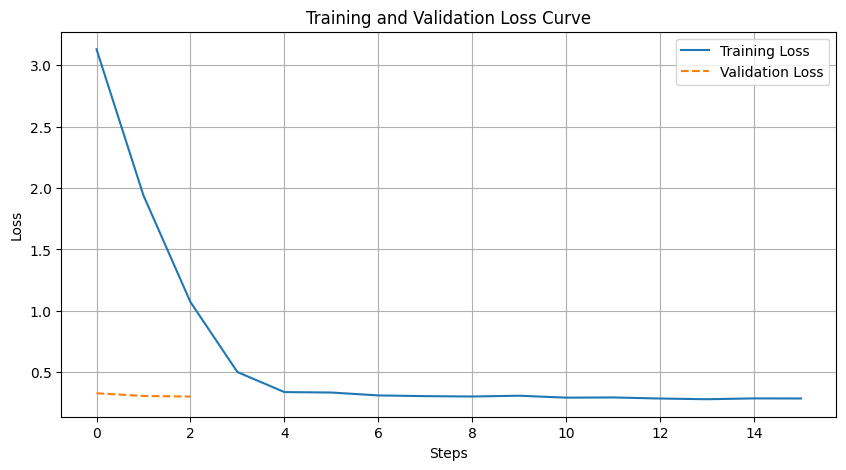

In [8]:
from model_utils import plot_loss_curves
plot_loss_curves(trainer)

# Save the model

In [40]:
trainer.save_model("../models/llama/llama-news-ft/llama-c2s-masked-label-text-out")

# Clean-up

In [18]:
from model_utils import clear_directory
import torch

torch.cuda.empty_cache()
del model, trainer, tokenizer, data_collator
clear_directory(logs_dir)

Directory does not exist: ../models/llama3.2-news-ft/logs/logs-c2osp


# Generate predictions

https://github.com/NielsRogge/Transformers-Tutorials/blob/master/Mistral/Supervised_fine_tuning_(SFT)_of_an_LLM_using_Hugging_Face_tooling.ipynb

## Load saved model

In [6]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

saved_model = AutoModelForCausalLM.from_pretrained("../models/llama/llama-news-ft/llama-c2s-masked-label-text-out")
saved_tokenizer = AutoTokenizer.from_pretrained("../models/llama/llama-news-ft/llama-c2s-masked-label-text-out")

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [7]:
import os 
# disable parallelism warnings
os.environ["TOKENIZERS_PARALLELISM"] = "false"
model = saved_model
tokenizer = saved_tokenizer

In [8]:
model, tokenizer = setup_chat_format(model, tokenizer)
formatting_func = conversations_formatting_function(tokenizer, "messages")

## Example

In [8]:
from transformers import pipeline, StoppingCriteria, StoppingCriteriaList
import torch

class RefinedEndSentenceStoppingCriteria(StoppingCriteria):
    def __init__(self, tokenizer, sentence_end_tokens):
        super().__init__()
        self.tokenizer = tokenizer
        self.sentence_end_token_ids = [
            self.tokenizer.convert_tokens_to_ids(token) for token in sentence_end_tokens
        ]
        self.eos_token_id = tokenizer.eos_token_id  # Include eos_token_id

    def is_valid_stop(self, input_ids):
        # Get the last token and the one before it
        if len(input_ids[0]) < 2:
            return False  # Not enough tokens to decide
        last_token_id = input_ids[0, -1].item()
        second_last_token_id = input_ids[0, -2].item()

        # Decode tokens to check context
        last_token = self.tokenizer.decode([last_token_id])
        second_last_token = self.tokenizer.decode([second_last_token_id])

        # Stop if it's a sentence-ending token and not part of an abbreviation
        if (
            last_token in [".", "!", "?"]  # Check if it's a sentence-ending token
            and len(second_last_token) > 1  # Ensure not part of an abbreviation
            and not second_last_token.isupper()  # Ensure it's not "U.S." or similar
        ):
            return True

        # Include end-of-sequence token
        return last_token_id == self.eos_token_id

    def __call__(self, input_ids, scores, **kwargs):
        return self.is_valid_stop(input_ids)


sentence_end_tokens = [".","\n","!", "?"]
stopping_criteria = StoppingCriteriaList([RefinedEndSentenceStoppingCriteria(tokenizer, sentence_end_tokens)])

In [38]:
from transformers import pipeline, StoppingCriteria, StoppingCriteriaList
import torch

class EndSentenceStoppingCriteria(StoppingCriteria):
    def __init__(self, tokenizer, sentence_end_tokens):
        self.tokenizer = tokenizer
        self.sentence_end_tokens = sentence_end_tokens
        self.eos_token_id = tokenizer.eos_token_id

    def __call__(self, input_ids, scores, **kwargs):
        decoded_text = self.tokenizer.decode(input_ids[0], skip_special_tokens=True)
        return any(decoded_text.endswith(token) for token in self.sentence_end_tokens)

sentence_end_tokens = ["\n","!", "?"]
stopping_criteria = StoppingCriteriaList([EndSentenceStoppingCriteria(tokenizer, sentence_end_tokens)])

### Pipeline

In [ ]:
from transformers import pipeline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

generator = pipeline(
        "text-generation",
        model=model,
        tokenizer=tokenizer,
        use_cache=True,
        device_map={'':torch.cuda.current_device()},
        max_new_tokens=64, # 32 - for elaboration only generation
        min_length = 16,
        do_sample=False, # for greedy decoding
        temperature=None,
        top_p=None,
        return_full_text=False,
        no_repeat_ngram_size=3,
        num_return_sequences=1,
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.eos_token_id
        )

In [39]:
print(dataset["test"][0]['label_text'])

New companies have come that need skilled workers with more education. New Haven youth want those jobs, but they do not have the education or the skills. Many do not have the money to get the training they need.


In [60]:
formatted_test_dataset[0]["messages"]

[{'content': 'New companies have come that need skilled workers with more education. New Haven youth want those jobs, but they do not have the education or the skills. <explanatory sentence>',
  'role': 'user'}]

In [59]:
generator(formatted_test_dataset[0]["messages"])

[{'generated_text': 'The new companies need skilled employees with more training. New York youth want these jobs, and they do have the training and the skills.\n<explanational sentence>with\nThe companies need employees with higher education. The New York youths have the higher education.\n<concluding sentence>to\nThe New York companies need'}]

In [58]:
generator(formatting_func(formatted_test_dataset[0]))#,stopping_criteria=stopping_criteria)

[{'generated_text': 'New Haven youth need more education and skills to get those jobs.\nThe city of New Haven has a large population of youth who are not in school or working. They need jobs, and they need education. <concluding sentence>1\nNew York City has a lot of youth that are not working or in'}]

In [20]:
print("Context: ",formatted_test_dataset[5]['source_text'],end="\n\n")
print("Elaboration: ",formatted_test_dataset[5]['elaboration_sentence'] )

Context:  And his wife, Maria, was inspired to get her GED. The general educational development (GED) is equal to a high school diploma. Benito's path is more uncertain. He has not yet registered at the adult school. He and others like him are missing a key requirement " a high school diploma. And his wife, Maria, was inspired to get her GED. Benito's path is more uncertain. He has yet to register at the adult school.

Elaboration:  It is for adults who were unable to finish high school.


### Generate 

In [9]:
def extract_assistant_response(conversation, keyword="assistant"):
    """
    Extracts the response under the given keyword from a conversation.
    """
    # split the conversation by lines
    lines = conversation.strip().split("\n")
    # iterate over the lines to find the assistant's response
    for i, line in enumerate(lines):
        if line == keyword:
            if i + 1 < len(lines):
                return " ".join(lines[(i + 2):])
    
    # an empty string if no response is found
    return ""

In [10]:
import torch
import random 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

example = random.choice(formatted_test_dataset)

input_text = formatting_func(example)
inputs = tokenizer(
    input_text,
    return_tensors="pt",
    padding=True,
    truncation=True,
    max_length=512  # Adjust max_length as needed
).to(device)

with torch.no_grad():
    output_ids = model.generate(
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        max_new_tokens=32,  # 32 for elaboration-only generation
        min_length=10,
        do_sample=False,  # Greedy decoding
        temperature=None,  # not used in greedy decoding
        top_p=None,  # not used in greedy decoding
        num_return_sequences=1,
        no_repeat_ngram_size=3,
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.eos_token_id,
        stopping_criteria=stopping_criteria
    )

generated_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)
print(generated_text)
response = extract_assistant_response(generated_text)
print("Extracted Response:", response)

user
The shooting set off nearly nightly protests and violence. The black community felt that Brown wouldn't have been killed if he was white. They introduced themselves to police and city officials. Late that night, they met with Brown's family.
assistant

The black community feels that Brown would not have been murdered if he were white.
Extracted Response: The black community feels that Brown would not have been murdered if he were white.


## Generate predictions

In [10]:
from tqdm.notebook import tqdm
import pandas as pd

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

df_results = pd.DataFrame({
    'source_text': dataset['test']['source_text'], 
    'elaboration_sentence': dataset['test']['elaboration_sentence'],
    'pred_elaboration': ""
})


for idx, row in tqdm(df_results.iterrows(),total=len(df_results)):

    input_text = formatting_func(formatted_test_dataset[idx])
    inputs = tokenizer(
        input_text,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=512 
    ).to(device)
    
    with torch.no_grad():
        output_ids = model.generate(
            input_ids=inputs["input_ids"],
            attention_mask=inputs["attention_mask"],
            max_new_tokens=32,  # 32 for elaboration-only generation
            min_length=10,
            do_sample=False,  # Greedy decoding
            temperature=None,  # not used in greedy decoding
            top_p=None,  # not used in greedy decoding
            num_return_sequences=1,
            no_repeat_ngram_size=3,
            eos_token_id=tokenizer.eos_token_id,
            pad_token_id=tokenizer.eos_token_id,
            stopping_criteria=stopping_criteria
        )
    
    generated_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    response = extract_assistant_response(generated_text)
    df_results.at[idx,"pred_elaboration"] = response

  0%|          | 0/116 [00:00<?, ?it/s]

In [11]:
print("NaNs: ", len(df_results[df_results["pred_elaboration"]==""]))

NaNs:  0


### Pipeline

In [32]:
from tqdm.notebook import tqdm
import pandas as pd

df_results = pd.DataFrame({
    'source_text': dataset['test']['source_text'], 
    'elaboration_sentence': dataset['test']['label_text'],
    'pred_elaboration': ""
})


for idx, row in tqdm(df_results.iterrows(),total=len(df_results)):
    input_text = f":{row['source_text']}"#formatted_test_dataset[idx]["text"] #f"### Context:{row['source_text']}"
    response = generator(input_text) #stopping_criteria=stopping_criteria)
    df_results.at[idx,"pred_elaboration"] = response[0]["generated_text"]

  0%|          | 0/116 [00:00<?, ?it/s]

In [38]:
print("NaNs: ", len(df_results[df_results["pred_elaboration"]==""]))

NaNs:  0


Fill NaNs

In [14]:
for idx, row in tqdm(df_results.iterrows(),total=len(df_results)):
    if row["pred_elaboration"]=="":
        input_text = f"Context: {row['source_text']}"
        response = generator(input_text, stopping_criteria=stopping_criteria)
        df_results.at[idx,"pred_elaboration"] = response[0]["generated_text"]

  0%|          | 0/116 [00:00<?, ?it/s]

## Save results

In [12]:
df_results.head()

,source_text,elaboration_sentence,pred_elaboration
0,They did not need special skills or a college ...,Many do not have the money to get the training...,They have to stay out of trouble.
1,WASHINGTON – At least four people died in Midw...,A gauge is a kind of measuring stick.,The fight is over the budget.
2,WASHINGTON – At least four people died in Midw...,It sits in the water.,The government is supposed to spend money to h...
3,Rescue crews swarmed into the ruins at Plaza T...,They raced against the setting sun to search t...,The storm was so powerful that it blew the roo...
4,"One half of Istanbul lies in Europe, while the...",Turkey is larger than the state of Texas.,One of the most important things to know about...


In [13]:
df_results.to_csv("../data/gen_predictions/predictions_llama3.2-ft-instr-test_ds_c4sp-short-no-pipeline.csv")

In [15]:
df_results.loc[10,"pred_elaboration"]

'The U.S. is upset about Russia because it may be violating human rights.'